In [1]:
# Package Load
import pickle
import pyLDAvis
import math
import copy
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tomotopy as tp
import tomotopy.coherence as tpc
from gensim.corpora import Dictionary
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
from timeit import default_timer
import plotly.express as px
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
version_name=str(datetime.today().strftime("%Y%m%d")) # 버전 정보 변수

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
os.chdir("C:\\Users\\newcomer02\\NTIS_Project")
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

## Option1 : 기존에 학습된 모델을 불러오기

In [3]:
# input : model 폴더명, 해당 폴더, 없으면 오류 발생 (원하는 버전 모델 있으면 지정, 없으면 Enter -> Default)
# model 폴더 안에 bin, npy 파일 필요, 없으면 오류 발생

lda_ver=input("불러올 LDA모델이 담긴 ./data/LDA 내 폴더 명을 입력하세요 (Default: 엔터키) : ")
if lda_ver=='':
    print("\nDefault LDA모델을 불러옵니다.")
    mdl=tp.LDAModel.load("./model/LDA_MODEL_20.bin")
#    lda_info =np.load("./data/LDA/Default/ict_index.npy")
else:
    print("\n%s 에 학습된 LDA모델을 불러옵니다."%(lda_ver[-8:]))
    mdl=tp.LDAModel.load("./model/"+lda_ver+"/LDA_MODEL_41.bin")
#    lda_info =np.load("./data/LDA/"+lda_ver+"/ict_index.npy")

불러올 LDA모델이 담긴 ./data/LDA 내 폴더 명을 입력하세요 (Default: 엔터키) :  



Default LDA모델을 불러옵니다.


## Option2 : 새로운 모델을 학습하기
### 코퍼스 파일 로드

In [4]:
folder_name=input("사용할 데이터 폴더명을 입력하세요(Default: 엔터키): ")
lda_txt="LDA_PRED_"+ folder_name
DATA_DIR = "./data/Default/"+ folder_name+ "/"
# NKIS, NTIS, REPORT, GOV
print(DATA_DIR + lda_txt)

사용할 데이터 폴더명을 입력하세요(Default: 엔터키):  NTIS


./data/Default/NTIS/LDA_PRED_NTIS


In [5]:
# input : data/LDA 폴더에 txt 형태 코퍼스 파일, 없으면 오류 발생

corpus=[]
for n, line in tqdm(enumerate(open(DATA_DIR+lda_txt+".txt", encoding='CP949'))):
    doc=line.strip().split()
    corpus.append(doc)
print("코퍼스 파일 로드가 완료되었습니다.")
start_num = int(input("시작년도를 입력해주세요:"))
end_num = int(input("마지막년도를 입력해주세요:"))

76684it [00:03, 20945.61it/s]


코퍼스 파일 로드가 완료되었습니다.


시작년도를 입력해주세요: 2017
마지막년도를 입력해주세요: 2021


In [6]:
 ##단어 없는 것 제거
temp = []
for cnt in range(len(corpus)):
    if len(corpus[cnt])  != 0 :
        temp.append(corpus[cnt])
        
corpus = temp

In [7]:
## 불용어

from string import ascii_lowercase
from string import ascii_uppercase
alphabet_list = list(ascii_lowercase) + list(ascii_uppercase)
alphabet_list.append("ㆍ")
#+ list(topic2["0"])
#print(len(topic2["0"]))
# 52부터 topic2 51까지 알파벳 대소문자 
#alphabet_list = alphabet_list[:550] #숫자만 바꿔주면됨 
len(alphabet_list)

53

In [8]:
unusing_dic = pd.DataFrame()
unusing_dic["term"] = alphabet_list

In [9]:
temp_f =[]
remove_set =unusing_dic["term"].tolist()

for temp_1 in tqdm(corpus) :
    temp_t = [temp_2 for temp_2 in temp_1 if temp_2 not in remove_set]
    temp_f.append(temp_t)
    
corpus = temp_f

100%|██████████████████████████████████████████████████████████████████████████| 76684/76684 [00:11<00:00, 6476.14it/s]


# LDA 모델 훈련

In [10]:
topic_num = int(input("사용할 토픽 수를 입력하세요. (※ 권장값 = 180개)"))
iteration = int(input("학습 Iteration 수를 입력하세요. (※ 1000이상의 자연수, 권장값 = 10000회)"))

print('\n %s개 토픽으로 %d회 LDA 학습을 진행합니다.'%(topic_num,iteration))

사용할 토픽 수를 입력하세요. (※ 권장값 = 180개) 20
학습 Iteration 수를 입력하세요. (※ 1000이상의 자연수, 권장값 = 10000회) 1000



 20개 토픽으로 1000회 LDA 학습을 진행합니다.


In [ ]:
# LDA 모델 학습 

s = default_timer()

mdl=tp.LDAModel(min_cf=1001, rm_top=64, k=topic_num, alpha=0.1, eta=0.01, tw=tp.TermWeight.PMI, seed=42)
for cnt in range(len(corpus)):
    mdl.add_doc(corpus[cnt])
mdl.train(iter=iteration, workers=0)

e = default_timer()
print("LDA 모델 학습이 완료되었습니다.")
print(f"{e-s} secs taken")

In [ ]:
# 학습된 모델 저장
# output type : 오늘 날짜 버전 bin 파일 저장

mdl.save('./model/'+data_ver+'/LDA_MODEL_'+str(topic_num)+'.bin')

## Option1 or Option2 수행 후 아래부터 실행

# LDA 결과 도출 및 시각화

# 모델 밖의 문헌 생성 후 추론하기

In [ ]:
## 토픽 및 시점별 단어분포 확인
for k in tqdm(range(mdl.k)):    
    print("Topic #{} ==".format(k+1))
    for word, prob in mdl.get_topic_words(k, top_n=50):
        print(word, prob, sep='\t')
    print()

In [12]:
yr_topic=[]
for i in range(len(corpus)):
    yr_topic.append(sorted(mdl.docs[i].get_topics(top_n=mdl.k), key=lambda x:x[0]))

topic_dist = list(np.zeros(mdl.k))
for i in yr_topic:
    for k in range(mdl.k):
        topic_dist[k] += i[k][1]
        
topic_dist/sum(topic_dist)

array([0.03978337, 0.05892911, 0.05773443, 0.05926897, 0.10230399,
       0.07351698, 0.05500291, 0.08644017, 0.03902141, 0.03048412,
       0.0188841 , 0.03957985, 0.05950214, 0.0443757 , 0.04896908,
       0.03799518, 0.02799783, 0.03228356, 0.04805931, 0.03986776])

In [13]:
yr_topic[0]

[(0, 2.392703026998788e-05),
 (1, 4.87605830130633e-05),
 (2, 0.291016161441803),
 (3, 4.2057294194819406e-05),
 (4, 8.199555304599926e-05),
 (5, 7.266410102602094e-05),
 (6, 4.55291556136217e-05),
 (7, 7.32711996533908e-05),
 (8, 0.4229889214038849),
 (9, 2.7572330509428866e-05),
 (10, 1.4363206901180092e-05),
 (11, 3.271999230491929e-05),
 (12, 4.6144199586706236e-05),
 (13, 0.11047565191984177),
 (14, 3.0548919312423095e-05),
 (15, 3.2872529118321836e-05),
 (16, 2.4428283722954802e-05),
 (17, 3.0964605684857816e-05),
 (18, 5.326183236320503e-05),
 (19, 0.005529350135475397)]

In [14]:
topics_d = []
for i in range(mdl.k):
    topic_d = str("topic_") + str(i+1)
    topics_d.append(topic_d)

In [15]:
ntis_topic_dist=pd.DataFrame(topic_dist/sum(topic_dist))
ntis_topic_dist['topic']=topics_d

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



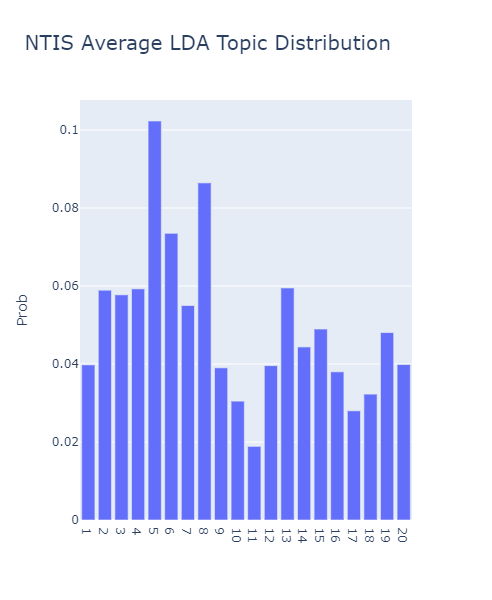

In [86]:
# output type : Average ICT NTIS/NEWS 연도별 html 파일 (html/DTM 폴더)

fig = make_subplots(
        rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1,
    )

fig.add_bar(x=[str(i+1) for i in range(len(topics_d))], y=ntis_topic_dist[0], name ="NTIS", row=1, col=1)
fig.update_layout(title=go.layout.Title(text=folder_name+" Average LDA Topic Distribution",
                                        font=go.layout.title.Font(size=20)),
                 yaxis_title="Prob", height=600)

fig.update_xaxes(visible=True, showticklabels=True)
fig.update_yaxes(visible=True, showticklabels=True)

fig.show()
#fig.write_html('./data/Default/'+folder_name+'/LDA/Output/'+folder_name+'_LDA_Topic'+str(topic_num)+'_Average_Distribution.html')


In [77]:
index = range(topic_num)
minus = ntis_topic_dist[0][ntis_topic_dist[0]>0.01].index
print(len(minus))

topics_dd = []
ntis_topic_dist_d =[]
real_index = [i for i in index if i not in minus]
for i in real_index :
    topics_dd.append(topics_d[i])
    ntis_topic_dist_d.append(ntis_topic_dist[0][i])

20


In [ ]:
# output type : Average ICT NTIS/NEWS 연도별 html 파일 (html/DTM 폴더)

fig = make_subplots(
        rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1
    )
fig.add_bar(x=topics_dd, y=ntis_topic_dist_d, name ="NTIS", row=1, col=1)
fig.update_layout(title=go.layout.Title(text="Average LDA Topic Distribution",
                                        font=go.layout.title.Font(size=20)),
                 yaxis_title="Prob")

fig.update_xaxes(visible=True, showticklabels=True)
fig.update_yaxes(visible=True, showticklabels=True)
fig.show()
#fig.write_html('./data/Default/'+folder_name+'/html/DTM/Average_DTM'+str(topic_num)+'.html')
#fig.write_html('./html/DTM/Average_DTM'+str(23)+'.html')

## 년도별 토픽 분포 세분화

In [26]:
# cc = pd.read_pickle("./data/Default/"+ folder_name + "/HAN_Filtered_" + folder_name+ ".pkl")
# cc =cc[cc["filtered_ICT"]==1][["year"]].reset_index(drop=True)
# cc.to_csv("./data/Default/"+ folder_name + "/HAN_year_" +folder_name+ ".csv")

In [87]:
df = pd.read_csv("./data/Default/"+folder_name+"/HAN_year_" + folder_name+ ".csv",index_col=0)

In [88]:
df["topic_dist"] = yr_topic

In [89]:
temp = []
for i in sorted(df["year"].unique().tolist()):
    temp.append(df[df["year"]==i].copy())
    
for i in temp:
    for j in range(topic_num):
        i["topic_dist_"+str(j+1)] = "a"
        
for u in temp:
    for i in tqdm(range(len(u["topic_dist"]))):
        for j in range(topic_num):
            u["topic_dist_"+str(j+1)].iloc[i] = u["topic_dist"].iloc[i][j][1]

  0%|                                                                                        | 0/12585 [00:00<?, ?it/s]C:\Users\newcomer02\AppData\Local\Temp\ipykernel_5336\1951531582.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 11%|████████▎                                                                   | 1379/12585 [00:05<00:48, 231.81it/s]

KeyboardInterrupt



In [73]:
dist = pd.DataFrame(index=range(topic_num),columns=[0,1,2,3,4])
j = 0
for u in temp:
    for i in tqdm(range(topic_num)):
        dist[j][i]=u.transpose().iloc[i+2].sum()
    j+=1
dist.columns= ["2017","2018","2019","2020","2021"]
## 에러나면 i+2 부분을 건드리면 해결됨

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.86it/s]


In [74]:
dist = dist/ np.array(dist.sum())

# 년도별 세분화 데이터 불러오기

In [90]:
#dist.to_csv("./data/Default/"+folder_name+ "/LDA/"+ folder_name+ "_Total_dist.csv")
dist = pd.read_csv("./data/Default/"+folder_name+ "/LDA/"+ folder_name+ "_Total_dist.csv",index_col=0)
dist

,2017,2018,2019,2020,2021
0,0.040563,0.038283,0.042368,0.038219,0.039691
1,0.062765,0.062426,0.056534,0.059269,0.055429
2,0.048286,0.054862,0.056113,0.060109,0.065332
3,0.050222,0.052262,0.058709,0.062631,0.067814
4,0.108048,0.113403,0.097889,0.098149,0.097790
5,0.077965,0.071228,0.069086,0.077873,0.071729
6,0.059316,0.059598,0.054907,0.051851,0.051742
7,0.089651,0.077007,0.090462,0.086416,0.087852
8,0.047119,0.044448,0.039885,0.035445,0.032212
9,0.028483,0.031518,0.031304,0.030530,0.030387


In [91]:
topics_d = []
for i in range(mdl.k):
    topic_d = str("topic_") + str(i+1)
    topics_d.append(topic_d)

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



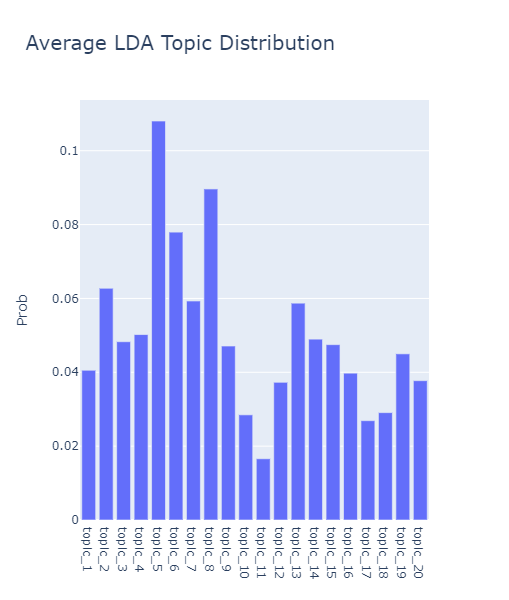

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



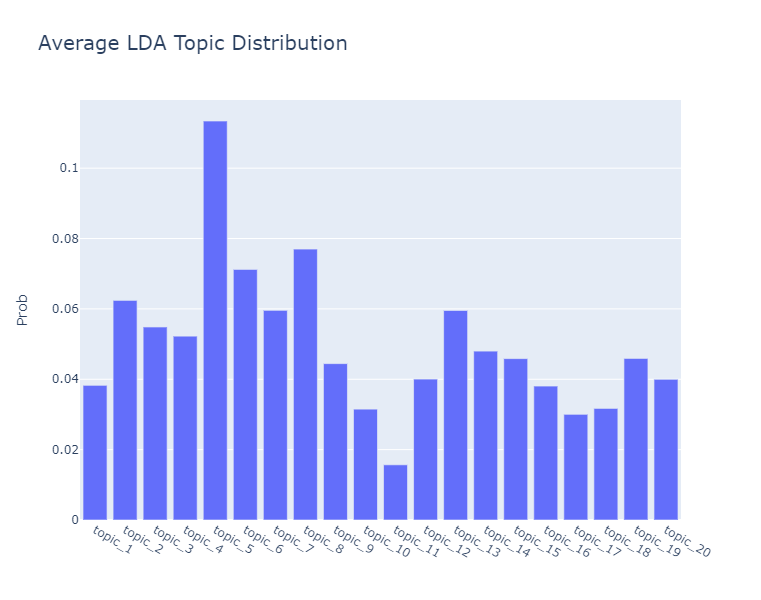

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



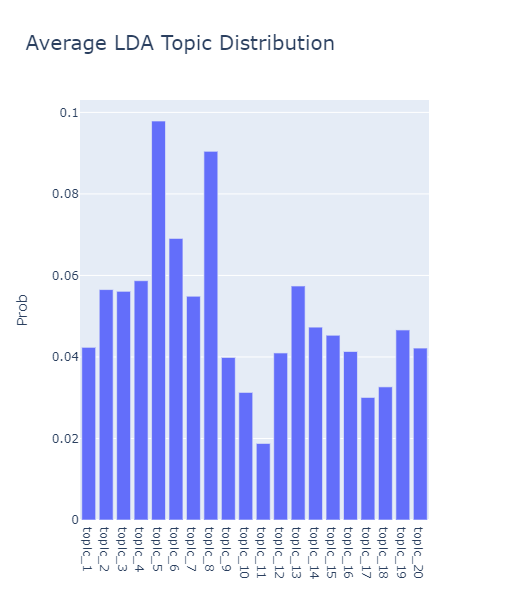

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



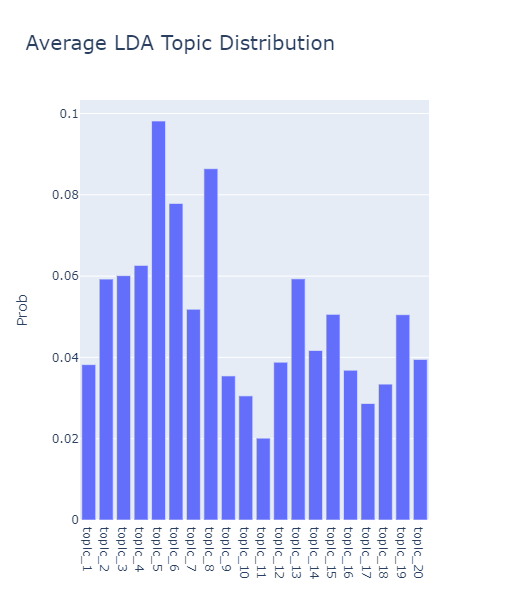

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



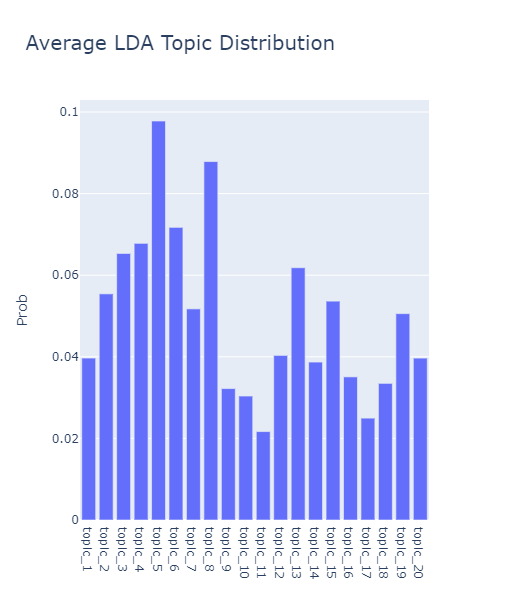

In [93]:
for i in dist.columns.tolist():
    # output type : Average ICT NTIS/NEWS 연도별 html 파일 (html/DTM 폴더)

    fig = make_subplots(
            rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1
        )
    fig.add_bar(x=topics_d, y=dist[i], name ="NTIS", row=1, col=1)
    fig.update_layout(title=go.layout.Title(text="Average LDA Topic Distribution",
                                            font=go.layout.title.Font(size=20)),
                     yaxis_title="Prob",height=600)

    fig.update_xaxes(visible=True, showticklabels=True)
    fig.update_yaxes(visible=True, showticklabels=True)
    fig.show()
    #fig.write_html('./html/DTM/Average_DTM'+str(num_topics)+'.html')
    #fig.write_html('./html/DTM/Average_DTM'+str(23)+'.html')

## 5개년 상위 토픽별 꺾은선 그래프

In [94]:
topn = pd.DataFrame(dist.sum(axis=1)).reset_index()
topn.set_index(["index"],inplace=True)
topn.sort_values(0,inplace=True,ascending=False)

In [95]:
zz = topn[:int(input("상위 토픽개수를 정해주시오:"))].index.tolist()

상위 토픽개수를 정해주시오: 20


In [96]:
color=[ 'aquamarine', 'black', 'blue',
            'blueviolet', 'brown', 'burlywood', 'cadetblue',
            'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
            'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
            'dimgray', 'dimgrey', 'dodgerblue', 'firebrick',
            'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
            'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green',
            'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo',
            'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen',
            'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan',
            'lightgoldenrodyellow', 'lightgray', 'lightgrey',
            'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen',
            'lightskyblue', 'lightslategray', 'lightslategrey',
            'lightsteelblue', 'lightyellow', 'lime', 'limegreen',
   #         linen, magenta, maroon, mediumaquamarine,
   #         mediumblue, mediumorchid, mediumpurple,
   ##         mediumseagreen, mediumslateblue, mediumspringgreen,
   #         mediumturquoise, mediumvioletred, midnightblue,
   #         mintcream, mistyrose, moccasin, navajowhite, navy,
   #         oldlace, olive, olivedrab, orange, orangered,
   #         orchid, palegoldenrod, palegreen, paleturquoise,
   #         palevioletred, papayawhip, peachpuff, peru, pink,
   #         plum, powderblue, purple, red, rosybrown,
   #         royalblue, rebeccapurple, saddlebrown, salmon,
   #         sandybrown, seagreen, seashell, sienna, silver,
   #         skyblue, slateblue, slategray, slategrey, snow,
    #        springgreen, steelblue, tan, teal, thistle, tomato,
    #        turquoise, violet, wheat, white, whitesmoke,
            'yellow', 'yellowgreen']

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



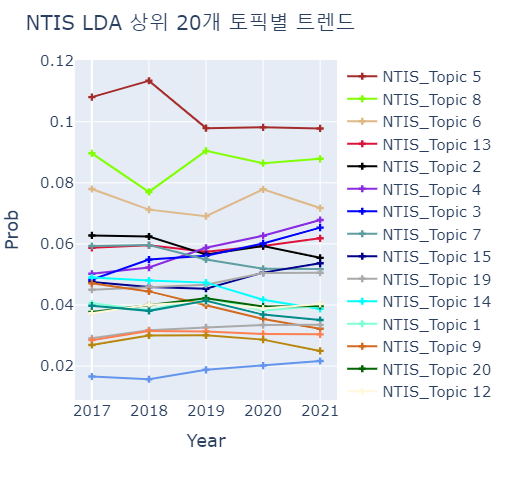

In [97]:
    total_ntis = []
    for i in zz:
        trace = go.Scatter(y = dist.iloc[i], mode = 'lines+markers',
                            hovertext='NTIS '+ str(i+1), 
                           hoverinfo='text',
                           name = 'NTIS_Topic '+ str(i+1),
                           marker=dict(symbol='cross', color=color[i]),
                          )
        total_ntis.append(trace)

    
    layout = go.Layout(title='NTIS LDA 상위 '+str(len(zz))+'개 토픽별 트렌드',legend=dict(font=dict(size=15)),margin=dict(l=20, r=20, t=60, b=100),paper_bgcolor="White",
                       autosize=True,title_font_size=20,font=dict(size=15),hoverlabel=dict(
        
        font_size=16,
        font_family="Rockwell"
    ),
                    xaxis=dict({"tickvals":[0,1,2,3,4],
                            "ticktext":dist.columns[:5].tolist(),
                           "title":"Year"}),
                    yaxis=dict({"title":"Prob"}),
                    height=500,width=500)
    
    gen_ntis = go.Figure(data=total_ntis, layout=layout)
    pyo.iplot(gen_ntis)

# 대표 문서 확인

In [84]:
for i in tqdm(range(mdl.k)) : 
    globals()['doc_to_{}'.format(str(i))] = 0
    globals()['doc_prob_{}'.format(str(i))] = 0
    globals()['doc_index_{}'.format(str(i))] = 0

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 19963.37it/s]


In [85]:
for k in tqdm(range(len(corpus))):
    temp_doc_to = mdl.docs[k].get_topics()[0][0]
    temp_doc_prob = mdl.docs[k].get_topics()[0][1]
    if globals()['doc_prob_{}'.format(str(temp_doc_to))] < temp_doc_prob :
        globals()['doc_to_{}'.format(str(temp_doc_to))] = temp_doc_to 
        globals()['doc_prob_{}'.format(str(temp_doc_to))] = temp_doc_prob
        globals()['doc_index_{}'.format(str(temp_doc_to))] = k

100%|████████████████████████████████████████████████████████████████████████| 76684/76684 [00:00<00:00, 158111.14it/s]


In [86]:
for k in tqdm(range(len(corpus))):
    temp_doc_to = mdl.docs[k].get_topics()[0][0]
    temp_doc_prob = mdl.docs[k].get_topics()[0][1]
    if globals()['doc_prob_{}'.format(str(temp_doc_to))] < temp_doc_prob :
        globals()['doc_to_{}'.format(str(temp_doc_to))] = temp_doc_to 
        globals()['doc_prob_{}'.format(str(temp_doc_to))] = temp_doc_prob
        globals()['doc_index_{}'.format(str(temp_doc_to))] = k

100%|████████████████████████████████████████████████████████████████████████| 76684/76684 [00:00<00:00, 207784.59it/s]


In [ ]:
for i in tqdm(range(mdl.k)) : 
    print("\n topic_" + str(i+1))
    print("index : " + str(globals()['doc_index_{}'.format(str(i))]))
    print("prob : " + str(globals()['doc_prob_{}'.format(str(i))]))
    print(mdl.docs[globals()['doc_index_{}'.format(str(i))]])

# 년도에 따른 토픽 별 대표문서 보기

In [11]:
year_range= input("몇개년 데이터인지 입력하시오 ex)5개년:5, 6개년:6 :")

몇개년 데이터인지 입력하시오 ex)5개년:5, 6개년:6 : 5


In [12]:
year_list = []
for i in range(int(year_range)):
    globals()["year_{}".format(str(i+2017))] = []
for i in range(int(year_range)):
    year_list.append(globals()["year_{}".format(str(i+2017))])

In [13]:
df_list = []
for i in range(int(year_range)):
    globals()["year_{}".format(str(i+2017))] = []
for i in range(int(year_range)):
    df_list.append(globals()["year_{}".format(str(i+2017))])
    for j in range(mdl.k):
        globals()["topic_{}".format(str(j+1))] = pd.DataFrame(columns=["index","prob"])
    for j in range(mdl.k):
        df_list[i].append(globals()["topic_{}".format(str(j+1))])

In [14]:
# import pandas as pd
# import os
# os.chdir("C:\\Users\\newcomer02\\NTIS_Project")
year_zz = pd.read_csv("./data/Default/"+folder_name+ "/HAN_year_"+folder_name+".csv",index_col=0)

In [15]:
j = 0
for i in range(start_num,end_num+1):
    year_list[j] = year_zz[year_zz==i].dropna().index.tolist()
    j +=1 

In [16]:
for i in tqdm(range(len(year_list))):
    for j in year_list[i]:
        if mdl.docs[j].get_topics()[0][1] > 0.5:
            df_list[i][mdl.docs[j].get_topics()[0][0]] =\
            pd.concat([df_list[i][mdl.docs[j].get_topics()[0][0]],
                   pd.DataFrame([(j,mdl.docs[j].get_topics()[0][1])],columns=["index","prob"])])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


In [17]:
for i in tqdm(range(len(df_list))):
    for j in range(len(df_list[i])):
        df_list[i][j] = df_list[i][j].sort_values("prob",ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 238.10it/s]


In [18]:
tt  = int(input("상위 몇개 토픽을 볼 것인지 입력하시오:"))

상위 몇개 토픽을 볼 것인지 입력하시오: 3


In [ ]:
for i in tqdm(range(mdl.k)) : 
    print("\n\n\n topic_" + str(i+1))
    for u in range(len(df_list)):
        print("\n\nYear_"+str(u+2017))
        for j in range(tt):
            print("index : " + str(df_list[u][i]["index"].iloc[:j+1].tolist()[j]))
            print("prob : " + str(df_list[u][i]["prob"].iloc[:j+1].tolist()[j]))

            print(mdl.docs[df_list[u][i]["index"].iloc[:j+1].tolist()[j]])

In [31]:
a = HAN_NTIS.iloc[226,:]["contents"].replace("\r","")
b = a.replace("\n","")
b.replace("tag","")


'o 밀리미터파 대역에서 배열 확장이 가능한 저전력  초소형 8 채널 빔포밍 RF 송수신단 개발  TRL 7      밀리미터파 대역 초소형  저전력 빔포밍 RF 송수신 IC 기술 개발     밀리미터파 대역 안테나와 RF 송수신단 결합 기술 개발     밀리미터파 빔포밍 테스트 베드 구축 o 밀리미터파 대역에서 배열 확장이 가능한 저전력  초소형 8 채널 빔포밍 RF 송수신단 개발  TRL 7      밀리미터파 대역 초소형  저전력 빔포밍 RF 송수신 IC 기술 개발     밀리미터파 대역 안테나와 RF 송수신단 결합 기술 개발     밀리미터파 빔포밍 테스트 베드 구축 1채널 빔포밍 IC 개별소자 설계기술을 바탕으로 1채널 및 8채널  통합 IC 설계기술기반을 마련하고  밀리미터파 대역의 개별 소자 설계기술을 확보함  또한 이러한 개별소자를 이용하여 소형 경량 저전력 타일형 송수신모듈 설계를 가능케 함'

In [24]:
list(range(0,5))

[0, 1, 2, 3, 4]

In [23]:
import os
os.chdir("C:\\Users\\newcomer02\\NTIS_Project")

In [20]:
import pandas as pd
HAN_NTIS = pd.read_pickle('./data\\Default\\NTIS\\HAN_Filtered_NTIS.pkl')

HAN_NTIS = HAN_NTIS[HAN_NTIS['filtered_ICT']==1]
HAN_NTIS.drop(HAN_NTIS[HAN_NTIS['contents']==""].index,inplace=True)
HAN_NTIS = HAN_NTIS.reset_index(drop=True)


## 토픽 관계 시각화

In [90]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [91]:
############################### pdavis 시각회 

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=1,
    sort_topics=False
)
#    pyLDAvis.save_html(prepared_data, 'dtmvis_{}.html'.format(timepoint))

C:\Users\newcomer02\Anaconda3\envs\mecab\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [ ]:
pyLDAvis.display(prepared_data)

# **텍스트 네트워크**

In [14]:
import pandas as pd
import networkx as nx
import operator
import numpy as np
import scipy

In [13]:
#pip install --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org scipy networkx==2.6.3

In [ ]:
wd_network = pd.DataFrame(index=range(len(corpus)),columns=["corpus","mdl.docs","Topic","Topic_prob"])

for i in tqdm(range(len(corpus))):
    wd_network.iloc[i][0] =  ' '.join(map(str, corpus[i]))

for j in tqdm(range(len(mdl.docs))):
    wd_network.iloc[j][1] = mdl.docs[j]

for z in tqdm(range(len(mdl.docs))):
    wd_network.iloc[z][2] = mdl.docs[z].get_topics(top_n=mdl.k)[0][0] + 1

for c in tqdm(range(len(mdl.docs))):
    wd_network.iloc[c][3] = mdl.docs[c].get_topics(top_n=mdl.k)[0][1]

wd_network["year"] = df["year"].astype(int).copy()

In [21]:
wd_network.to_csv("./data/Default/"+folder_name+"/LDA/" + folder_name+ "_wd_network_"+str(topic_num)+".csv",encoding="cp949")

### var진행하기 위한 dist파일 쓰기 

In [ ]:
# dist["Topic"] = topics_d
# dist = dist.set_index("Topic")
# dist.to_csv("dist_NTIS.csv")

# VAR word_dist 데이터 추출 과정

In [22]:
from collections import Counter
wd_network= pd.read_csv("./data/Default/"+folder_name+ "/LDA/" + folder_name+"_wd_network_"+ str(topic_num)+".csv",encoding="cp949",index_col=0)


In [23]:
word_dist = pd.DataFrame()
for i in range(topic_num):
    dtfrm = pd.DataFrame(mdl.get_topic_words(i,1000000),columns=["word","prob"])
    dtfrm["topic"] = i+1
    dtfrm = dtfrm.sort_values("prob",ascending=False)
    word_dist = pd.concat([word_dist,dtfrm])
word_dist = word_dist[["word","topic","prob"]]

In [24]:
word_dist

,word,topic,prob
0,소자,1,3.402182e-02
1,물질,1,2.162838e-02
2,반도체,1,1.433604e-02
3,소재,1,1.427215e-02
4,양자,1,1.255960e-02
...,...,...,...
1927,엔진,20,7.153524e-09
1926,업그레이드,20,7.153524e-09
1925,기능성,20,7.153524e-09
1924,개인정보,20,7.153524e-09


In [25]:
for c in tqdm(range(start_num,end_num+1)):
    final = pd.DataFrame()
    for i in range(topic_num):
        temp = []
        using_word = word_dist[word_dist["topic"]==i+1]["word"].tolist()
        zzz=wd_network[(wd_network["year"]==c) & (wd_network["Topic"]==i+1)]
        for j in range(len(zzz)):
            aa = zzz["corpus"].iloc[j].split(" ")
            for u in aa:
                if u in using_word:
                    temp.append(u)
                else:
                    continue
        df = pd.DataFrame(Counter(temp).most_common())
        df["topic"]= i+1
        df[c]= df[1]/sum(df[1])
        final = pd.concat([final,df])
        final.pop(1)
    if c == start_num:
        final_dist = final.copy()
    else: 
        final_dist = pd.merge(final_dist,final, on=["topic",0])
        

final_dist["labels"]= final_dist["topic"].apply(lambda x: "topic" + str(x)+": " + ','.join(pd.DataFrame(mdl.get_topic_words(x-1,5))[0].tolist()))
final_dist.columns = ["word","topic"] + list(range(start_num,end_num+1)) + ["labels"]
final_dist = final_dist[["word","labels","topic"]  + list(range(start_num,end_num+1))]


index_list = []
for i in range(topic_num):
    index_list = index_list + list(range(sum(final_dist["topic"]==(i+1))))
final_dist["index"] = index_list
final_dist=final_dist.set_index("index")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:12<00:00, 62.55s/it]


In [26]:
final_dist

,word,labels,topic,2017,2018,2019,2020,2021
index,,,,,,,,
0,소자,"topic1: 소자,물질,반도체,소재,양자",1,0.035317,0.032711,0.031305,0.030119,0.028260
1,반도체,"topic1: 소자,물질,반도체,소재,양자",1,0.014534,0.013750,0.015127,0.013609,0.013442
2,물질,"topic1: 소자,물질,반도체,소재,양자",1,0.012998,0.012970,0.013769,0.012666,0.013261
3,소재,"topic1: 소자,물질,반도체,소재,양자",1,0.012411,0.011488,0.010456,0.013525,0.015009
4,응용,"topic1: 소자,물질,반도체,소재,양자",1,0.008907,0.008078,0.008010,0.007915,0.008158
...,...,...,...,...,...,...,...,...
1816,개발기,"topic20: 로봇,3D,3차원,이미지,인식",20,0.000017,0.000029,0.000048,0.000023,0.000042
1817,사용량,"topic20: 로봇,3D,3차원,이미지,인식",20,0.000017,0.000029,0.000036,0.000034,0.000032
1818,유럽,"topic20: 로봇,3D,3차원,이미지,인식",20,0.000017,0.000131,0.000036,0.000034,0.000084


In [27]:
final_dist.to_pickle("./data/Default/" +folder_name+ "/LDA/"+ "WORDS_NTIS_" + str(topic_num)+".pkl")

In [28]:
pd.read_pickle("./data/Default/" +folder_name+ "/LDA/"+ "WORDS_NTIS_" + str(topic_num)+".pkl")

,word,labels,topic,2017,2018,2019,2020,2021
index,,,,,,,,
0,소자,"topic1: 소자,물질,반도체,소재,양자",1,0.035317,0.032711,0.031305,0.030119,0.028260
1,반도체,"topic1: 소자,물질,반도체,소재,양자",1,0.014534,0.013750,0.015127,0.013609,0.013442
2,물질,"topic1: 소자,물질,반도체,소재,양자",1,0.012998,0.012970,0.013769,0.012666,0.013261
3,소재,"topic1: 소자,물질,반도체,소재,양자",1,0.012411,0.011488,0.010456,0.013525,0.015009
4,응용,"topic1: 소자,물질,반도체,소재,양자",1,0.008907,0.008078,0.008010,0.007915,0.008158
...,...,...,...,...,...,...,...,...
1816,개발기,"topic20: 로봇,3D,3차원,이미지,인식",20,0.000017,0.000029,0.000048,0.000023,0.000042
1817,사용량,"topic20: 로봇,3D,3차원,이미지,인식",20,0.000017,0.000029,0.000036,0.000034,0.000032
1818,유럽,"topic20: 로봇,3D,3차원,이미지,인식",20,0.000017,0.000131,0.000036,0.000034,0.000084


# 각 토픽 별 문서 추출

In [31]:
data = pd.read_pickle("./data\\Default\\" + folder_name + "\\HAN_Filtered_"+folder_name+".pkl")

In [32]:
data = data[data["filtered_ICT"]==1]
data = data[data["contents"]!=""].reset_index(drop=True)
HAN_yc = data[["year","contents"]].reset_index(drop=True)

In [33]:
topic_list = []
topic_prob_list = []
for i in range(len(mdl.docs)):
    topic_list.append(mdl.docs[i].get_topics()[0][0])
    topic_prob_list.append(mdl.docs[i].get_topics()[0][1])

In [34]:
df_topic = pd.DataFrame({"topic":topic_list,"topic_prob":topic_prob_list})
# df_topic = pd.concat([HAN_yc,df_topic],axis=1)
# df_topic["topic"]= df_topic["topic"]+1
df_topic = df_topic[df_topic["topic_prob"]> 0.5]

In [35]:
topic_idx_list = [[] for i in range(topic_num)]

In [36]:
for i in range(topic_num):
    topic_idx_list[i] = df_topic[df_topic["topic"]== i].index

In [37]:
# 검산
aa = []
for i in range(topic_num):
    aa.append(topic_idx_list[i].tolist())
len(sum(aa,[]))

29138

In [38]:
corpus_topic = [[] for i in range(topic_num)]
for i in range(topic_num):
    for j in topic_idx_list[i]:
        corpus_topic[i].append(corpus[j])

In [39]:
# 검산
print(len(corpus_topic))
z = 0
for i in range(topic_num):
    z += len(corpus_topic[i])
z

20


29138

In [40]:
for j in tqdm(range(topic_num)):
    f = open("./data/Default/NTIS/LDA/corpus_topic/"+"LDA_topic_"+str(j+1)+".txt","w")
    for i in range(len(corpus_topic[j])):
        f.writelines(' '.join(corpus_topic[j][i])+"\n")
    f.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]


In [ ]:
# 10번 토픽 예시로 추출

In [ ]:
corpus_topic_10=[]
for n, line in tqdm(enumerate(open("./data/Default/NTIS/LDA/corpus_topic/" + "LDA_topic_10.txt", encoding='CP949'))):
    doc=line.strip().split()
    corpus_topic_10.append(doc)

In [ ]:
sct1 = sum(corpus_topic_10,[])

In [ ]:
from collections import Counter

In [ ]:
df_sct1 = pd.DataFrame(Counter(sct1).most_common(),columns=["word","count"])

In [ ]:
df_sct1.to_excel("topic_10_wordcount.xlsx",index=False)